# HR Analytics - Employee Attrition Prediction

**Goal:** predict the probability of voluntary attrition and identify the main drivers to support retention decisions.

**Notebook scope**
- Initial data exploration and quality checks
- Feature engineering and preprocessing
- Modeling (baseline + tree) and evaluation
- Insights and next steps


In [16]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    precision_score,
    recall_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    fbeta_score,
    make_scorer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

RANDOM_STATE = 42

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False


## 1. Data loading


In [17]:
DATA_PATH = Path("data/dataset.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(
        "File not found. Put the dataset in data/dataset.csv or update DATA_PATH."
    )

df = pd.read_csv(DATA_PATH)
print("Rows, columns:", df.shape)
df.head()


Rows, columns: (23058, 30)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Employee Source,AgeStartedWorking
0,41,Voluntary Resignation,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,0,8,0,1,6,4,0,5,Referral,33
1,37,Voluntary Resignation,Travel_Rarely,Human Resources,6,4,Human Resources,1,Female,3,...,0,8,0,1,6,4,0,5,Referral,29
2,41,Voluntary Resignation,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,0,8,0,1,6,4,0,5,Referral,33
3,37,Voluntary Resignation,Travel_Rarely,Human Resources,6,4,Marketing,1,Female,3,...,0,8,0,1,6,4,0,5,Referral,29
4,37,Voluntary Resignation,Travel_Rarely,Human Resources,6,4,Human Resources,1,Female,3,...,0,8,0,1,6,4,0,5,Referral,29


## 2. Data overview and quality

Here we take a quick look at the dataset structure, checking types, missing values, and duplicates.


In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23058 entries, 0 to 23057
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       23058 non-null  int64 
 1   Attrition                 23058 non-null  object
 2   BusinessTravel            23058 non-null  object
 3   Department                23058 non-null  object
 4   DistanceFromHome          23058 non-null  int64 
 5   Education                 23058 non-null  int64 
 6   EducationField            23058 non-null  object
 7   EnvironmentSatisfaction   23058 non-null  int64 
 8   Gender                    23058 non-null  object
 9   JobInvolvement            23058 non-null  int64 
 10  JobLevel                  23058 non-null  int64 
 11  JobRole                   23058 non-null  object
 12  JobSatisfaction           23058 non-null  int64 
 13  MaritalStatus             23058 non-null  object
 14  MonthlyIncome         

In [19]:
missing = df.isna().sum().sort_values(ascending=False)
missing.head(10)


Age                        0
Attrition                  0
Employee Source            0
YearsWithCurrManager       0
YearsSinceLastPromotion    0
YearsInCurrentRole         0
YearsAtCompany             0
WorkLifeBalance            0
TrainingTimesLastYear      0
TotalWorkingYears          0
dtype: int64

In [20]:
duplicates = df.duplicated().sum()
print("Duplicados:", duplicates)


Duplicados: 14882


## 3. Target distribution

Understanding target imbalance is essential to choose metrics and modeling techniques.


In [21]:
if "Attrition" in df.columns:
    df["Attrition"].value_counts()


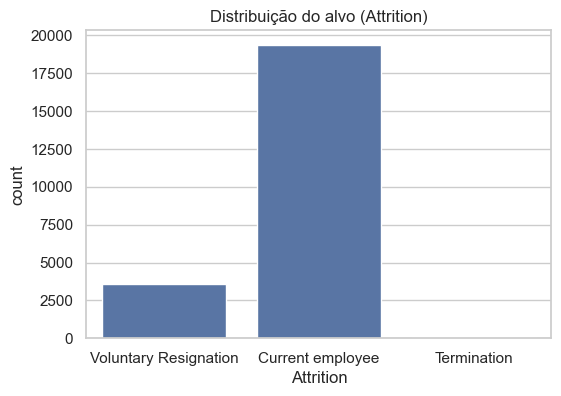

In [22]:
if "Attrition" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x="Attrition", data=df)
    plt.title("Distribuição do alvo (Attrition)")
    plt.show()


## 4. Feature preparation and engineering

- Standardize categorical types
- Numeric conversions
- Features derived from experience and tenure


In [23]:
# Normaliza nomes de colunas (remove espa?os extras)
df.columns = df.columns.str.strip()

# Converte colunas categóricas (se existirem)
categorical_columns = [
    "Attrition", "BusinessTravel", "Department", "Education", "EducationField", "Employee Source",
    "EnvironmentSatisfaction", "Gender", "JobInvolvement", "JobLevel", "JobRole", "JobSatisfaction",
    "MaritalStatus", "OverTime", "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance",
]
categorical_columns = [c for c in categorical_columns if c in df.columns]
if categorical_columns:
    df[categorical_columns] = df[categorical_columns].astype("category")


num_int_cols = ["DistanceFromHome", "MonthlyIncome", "PercentSalaryHike"]
num_int_cols = [c for c in num_int_cols if c in df.columns]
if num_int_cols:
    df[num_int_cols] = df[num_int_cols].apply(pd.to_numeric, errors="coerce")

# Engenharia de atributos
required_cols = {"TotalWorkingYears", "YearsAtCompany", "NumCompaniesWorked"}
if required_cols.issubset(df.columns):
    df["PriorYearsOfExperience"] = df["TotalWorkingYears"] - df["YearsAtCompany"]
    df["AverageTenure"] = df["PriorYearsOfExperience"] / df["NumCompaniesWorked"].replace(0, np.nan)
    df["AverageTenure"] = df["AverageTenure"].fillna(0)


## 5. Target definition and features

We focus on **voluntary attrition** when that class exists. If the dataset uses `Yes/No`, we adapt automatically.


In [24]:
if "Attrition" not in df.columns:
    raise ValueError("Column 'Attrition' not found in the dataset.")

# Normalize target values
attrition = df["Attrition"].astype(str).str.strip()

# Possible labels for leaving and staying
positive_candidates = [
    "Voluntary Resignation", "Yes", "Leave", "Left", "Attrition", "Resigned"
]
negative_candidates = [
    "Current employee", "No", "Stay", "Active", "Employed"
]

positive_class = next((c for c in positive_candidates if c in attrition.unique()), None)
negative_class = next((c for c in negative_candidates if c in attrition.unique()), None)

if not positive_class or not negative_class:
    raise ValueError(
        "Expected classes not found in the target. Check values in 'Attrition'. "
        f"Values found: {sorted(attrition.unique())}"
    )

mask = attrition.isin([positive_class, negative_class])

df_model = df[mask].copy()

df_model["AttritionBinary"] = (
    df_model["Attrition"].astype(str).str.strip() == positive_class
).astype(int)

feature_cols = [
    "Age", "Department", "DistanceFromHome", "Employee Source", "JobRole", "MaritalStatus",
    "AverageTenure", "PriorYearsOfExperience", "Gender", "Education", "EducationField",
    "MonthlyIncome", "OverTime", "JobSatisfaction", "WorkLifeBalance"
]
feature_cols = [c for c in feature_cols if c in df_model.columns]

X = df_model[feature_cols]
y = df_model["AttritionBinary"]

print("Positive class:", positive_class)
print("Negative class:", negative_class)
print("Features used:", feature_cols)
print("Positive rate:", y.mean().round(3))


Positive class: Voluntary Resignation
Negative class: Current employee
Features used: ['Age', 'Department', 'DistanceFromHome', 'Employee Source', 'JobRole', 'MaritalStatus', 'AverageTenure', 'PriorYearsOfExperience', 'Gender', 'Education', 'EducationField', 'MonthlyIncome', 'OverTime', 'JobSatisfaction', 'WorkLifeBalance']
Positive rate: 0.157


## 6. Train/test split and preprocessing

We use a stratified split to preserve the target proportion in train and test sets.


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["number", "bool"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features),
    ],
    remainder="drop",
)


## 7. Baseline model - Logistic Regression

Logistic regression is a strong and interpretable baseline. We use `class_weight='balanced'` to handle imbalance.


              precision    recall  f1-score   support

        Stay       0.91      0.68      0.78      3875
       Leave       0.28      0.66      0.39       720

    accuracy                           0.68      4595
   macro avg       0.60      0.67      0.59      4595
weighted avg       0.81      0.68      0.72      4595

ROC AUC: 0.718
F2-Score: 0.516


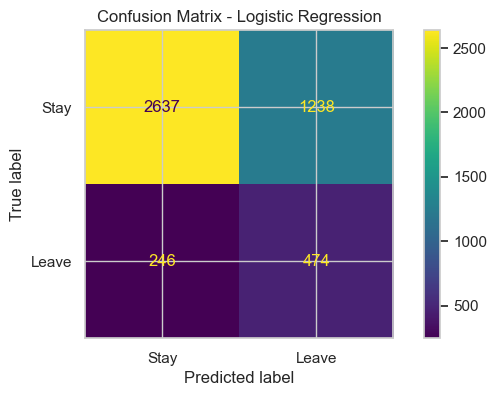

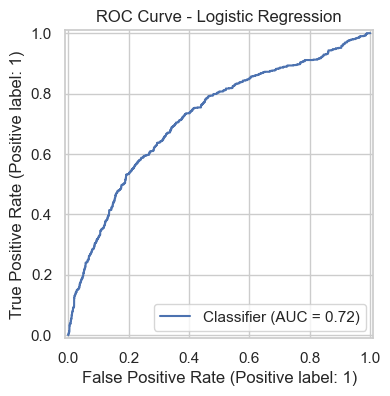

In [26]:
log_reg = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "model",
            LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
        ),
    ]
)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=["Stay", "Leave"]))
print("ROC AUC:", roc_auc_score(y_test, y_proba).round(3))
print("F2-Score:", fbeta_score(y_test, y_pred, beta=2).round(3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Stay", "Leave"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Logistic Regression")
plt.show()


### Cross-validation (optional)

Measures model stability with stratified k-fold.


In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

f2_scorer = make_scorer(fbeta_score, beta=2)

cv_scores = cross_validate(
    log_reg,
    X,
    y,
    cv=cv,
    scoring={"roc_auc": "roc_auc", "f2": f2_scorer},
    n_jobs=-1,
)

pd.DataFrame({
    "roc_auc_mean": [np.mean(cv_scores["test_roc_auc"])],
    "f2_mean": [np.mean(cv_scores["test_f2"])],
})


,roc_auc_mean,f2_mean
0,0.714153,0.510202


## 8. Decision tree and interpretability

Decision trees help explain model logic and the main drivers. We prune at depth 3 to reduce overfitting.


              precision    recall  f1-score   support

        Stay       0.85      1.00      0.92      3875
       Leave       0.82      0.03      0.06       720

    accuracy                           0.85      4595
   macro avg       0.83      0.52      0.49      4595
weighted avg       0.84      0.85      0.78      4595

ROC AUC: 0.685
F2-Score: 0.04


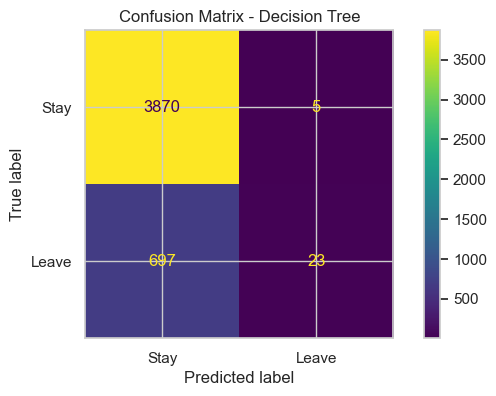

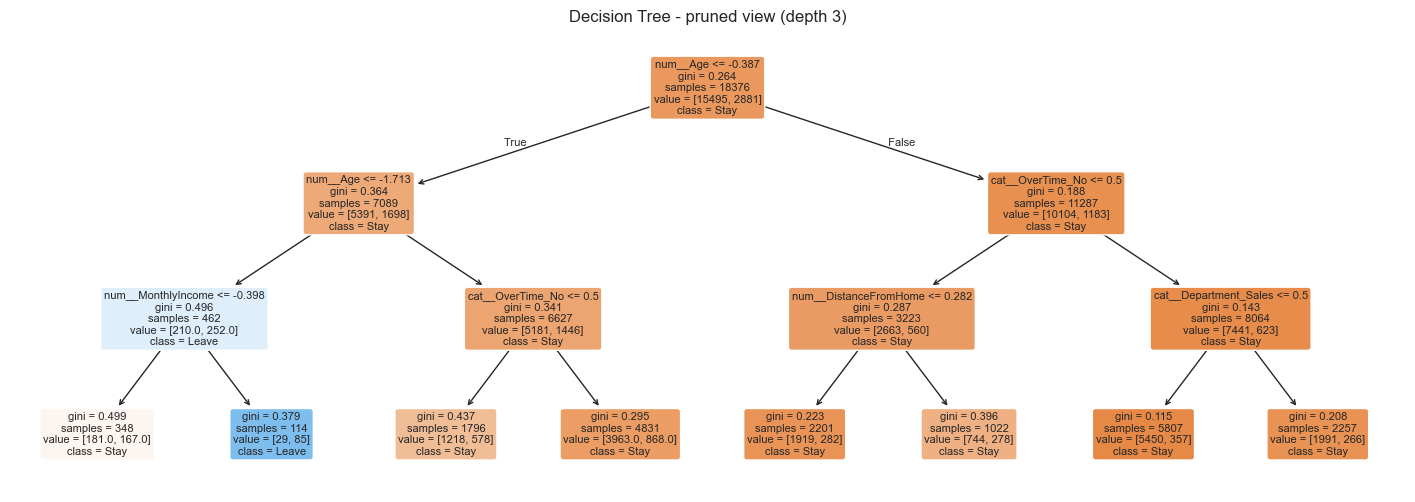

In [28]:
tree = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "model",
            DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE),
        ),
    ]
)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

tree_proba = tree.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_tree, target_names=["Stay", "Leave"]))
print("ROC AUC:", roc_auc_score(y_test, tree_proba).round(3))
print("F2-Score:", fbeta_score(y_test, y_pred_tree, beta=2).round(3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree, display_labels=["Stay", "Leave"])
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Decision tree (pruned view - depth 3)
feature_names = tree.named_steps["preprocess"].get_feature_names_out()
plt.figure(figsize=(18, 6))
plot_tree(
    tree.named_steps["model"],
    feature_names=feature_names,
    class_names=["Stay", "Leave"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8,
)
plt.title("Decision Tree - pruned view (depth 3)")
plt.show()


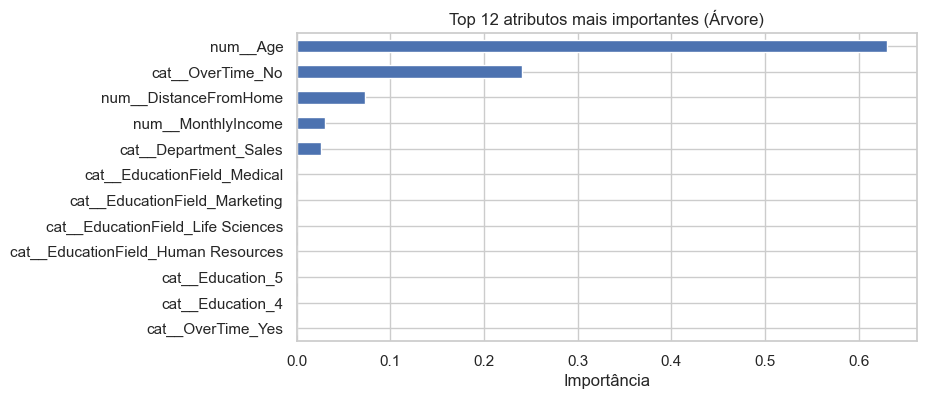

In [29]:
# Importância de atributos
feature_names = tree.named_steps["preprocess"].get_feature_names_out()
importances = tree.named_steps["model"].feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=False)
    .head(12)
)

feat_imp.sort_values().plot(kind="barh")
plt.title("Top 12 atributos mais importantes (Árvore)")
plt.xlabel("Importância")
plt.show()


## 9. XGBoost (optional)

A more robust model for performance, if available in the environment.


              precision    recall  f1-score   support

        Stay       0.89      0.99      0.94      3875
       Leave       0.90      0.37      0.53       720

    accuracy                           0.89      4595
   macro avg       0.90      0.68      0.73      4595
weighted avg       0.90      0.89      0.88      4595

ROC AUC: 0.925
F2-Score: 0.422


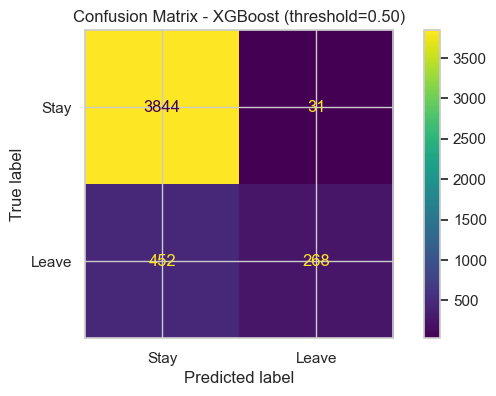

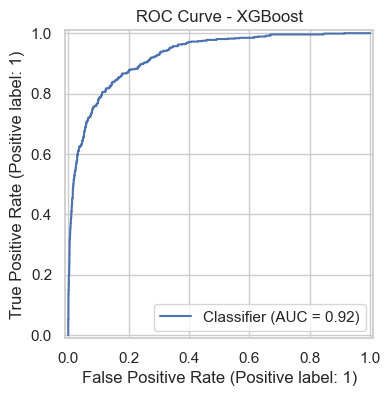

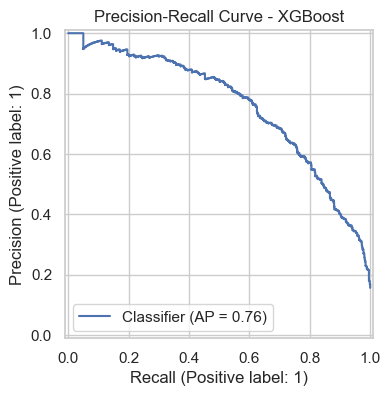

,threshold,precision,recall,f2
0,0.10,0.320702,0.963889,0.687946
1,0.15,0.432175,0.880556,0.729239
2,0.20,0.545961,0.816667,0.742987
3,0.25,0.638889,0.734722,0.713323
4,0.30,0.706587,0.655556,0.665163
5,0.35,0.786116,0.581944,0.613829
6,0.40,0.841014,0.506944,0.550694
7,0.45,0.863014,0.437500,0.485362
8,0.50,0.896321,0.372222,0.421516
9,0.55,0.923077,0.300000,0.346821


Chosen threshold (recall-first, min precision=0.3): 0.10
              precision    recall  f1-score   support

        Stay       0.99      0.62      0.76      3875
       Leave       0.32      0.96      0.48       720

    accuracy                           0.67      4595
   macro avg       0.66      0.79      0.62      4595
weighted avg       0.88      0.67      0.72      4595

F2-Score (tuned): 0.688


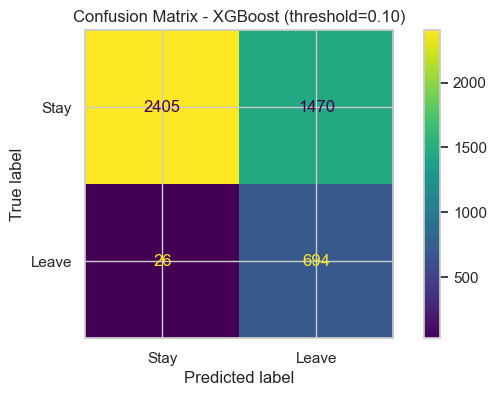

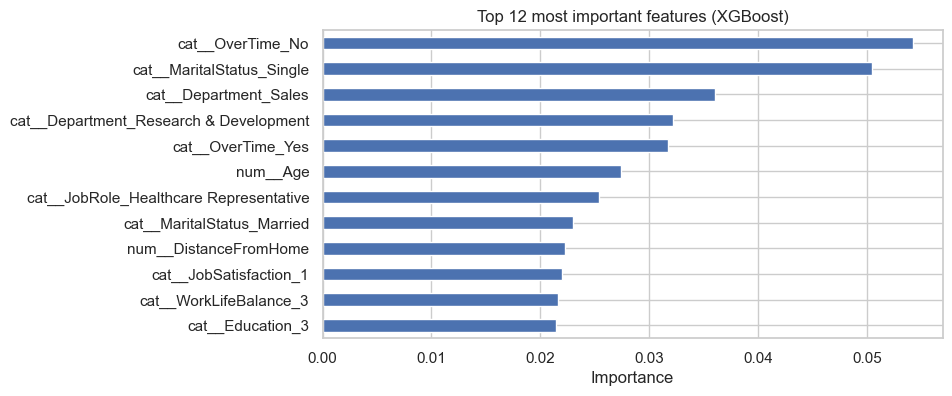

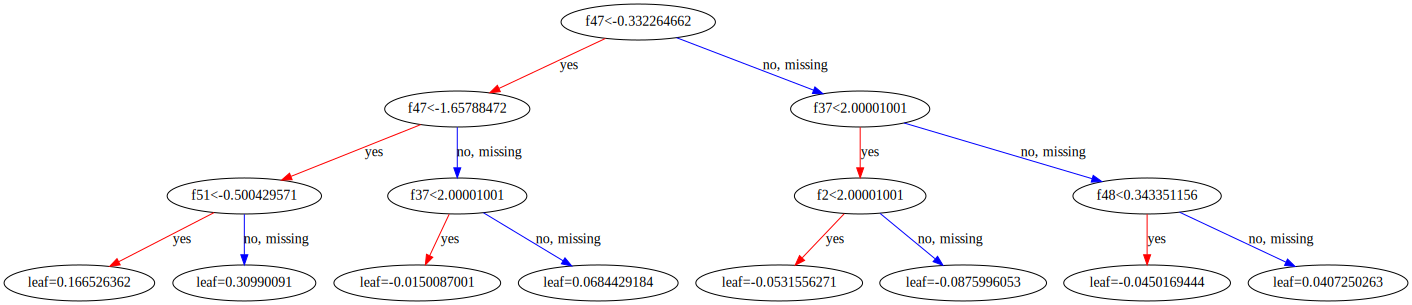

In [30]:
if HAS_XGB:
    xgb_clf = xgb.XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
    )

    xgb_pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", xgb_clf),
        ]
    )

    xgb_pipe.fit(X_train, y_train)
    y_pred_xgb = xgb_pipe.predict(X_test)
    y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred_xgb, target_names=["Stay", "Leave"]))
    print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb).round(3))
    print("F2-Score:", fbeta_score(y_test, y_pred_xgb, beta=2).round(3))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=["Stay", "Leave"])
    plt.title("Confusion Matrix - XGBoost (threshold=0.50)")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba_xgb)
    plt.title("ROC Curve - XGBoost")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba_xgb)
    plt.title("Precision-Recall Curve - XGBoost")
    plt.show()

    # Threshold tuning (recall-first)
    thresholds = np.arange(0.10, 0.91, 0.05)
    rows = []
    for t in thresholds:
        pred_t = (y_proba_xgb >= t).astype(int)
        rows.append({
            "threshold": round(float(t), 2),
            "precision": precision_score(y_test, pred_t, zero_division=0),
            "recall": recall_score(y_test, pred_t, zero_division=0),
            "f2": fbeta_score(y_test, pred_t, beta=2),
        })

    thr_df = pd.DataFrame(rows).sort_values("threshold")
    display(thr_df)

    min_precision = 0.30
    candidates = thr_df[thr_df["precision"] >= min_precision]
    if candidates.empty:
        best_row = thr_df.loc[thr_df["recall"].idxmax()]
    else:
        best_row = candidates.loc[candidates["recall"].idxmax()]

    best_t = float(best_row["threshold"])
    print(f"Chosen threshold (recall-first, min precision={min_precision}): {best_t:.2f}")

    y_pred_xgb_adj = (y_proba_xgb >= best_t).astype(int)
    print(classification_report(y_test, y_pred_xgb_adj, target_names=["Stay", "Leave"]))
    print("F2-Score (tuned):", fbeta_score(y_test, y_pred_xgb_adj, beta=2).round(3))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb_adj, display_labels=["Stay", "Leave"])
    plt.title(f"Confusion Matrix - XGBoost (threshold={best_t:.2f})")
    plt.show()

    # Feature importance
    feature_names = xgb_pipe.named_steps["preprocess"].get_feature_names_out()
    importances = xgb_pipe.named_steps["model"].feature_importances_

    feat_imp = (
        pd.Series(importances, index=feature_names)
        .sort_values(ascending=False)
        .head(12)
    )

    feat_imp.sort_values().plot(kind="barh")
    plt.title("Top 12 most important features (XGBoost)")
    plt.xlabel("Importance")
    plt.show()

    # XGBoost tree (first tree)
    try:
        graph = xgb.to_graphviz(xgb_clf, num_trees=0)
        display(graph)
    except Exception as exc:
        print("Could not render XGBoost tree:", exc)
else:
    print("XGBoost not installed. Install xgboost to run this section.")


## Model comparison (precision, recall, ROC AUC)

This section summarizes the key metrics for each model and provides a short recommendation based on the business goal.


In [31]:
# Collect metrics for all models in a comparable table
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": tree,
    "XGBoost": xgb_pipe if HAS_XGB else None,
}

rows = []
for name, model in models.items():
    if model is None:
        continue
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    rows.append({
        "model": name,
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "f2": fbeta_score(y_test, y_pred, beta=2),
    })

results_df = pd.DataFrame(rows).sort_values("roc_auc", ascending=False)
results_df

# Recommendation (recall-first for retention)
if HAS_XGB:
    # Use tuned threshold from XGBoost section if available
    try:
        tuned_threshold = best_t
    except NameError:
        tuned_threshold = 0.5

    y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
    y_pred_xgb_tuned = (y_proba_xgb >= tuned_threshold).astype(int)

    tuned_metrics = {
        "precision": precision_score(y_test, y_pred_xgb_tuned, zero_division=0),
        "recall": recall_score(y_test, y_pred_xgb_tuned, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba_xgb),
        "f2": fbeta_score(y_test, y_pred_xgb_tuned, beta=2),
    }

    print("Recommended model for retention (recall-first): XGBoost with tuned threshold")
    print("Tuned threshold:", round(float(tuned_threshold), 2))
    print({k: round(v, 3) for k, v in tuned_metrics.items()})
else:
    print("Recommended model for retention (recall-first): Logistic Regression")


Recommended model for retention (recall-first): XGBoost with tuned threshold
Tuned threshold: 0.1
{'precision': 0.321, 'recall': 0.964, 'roc_auc': 0.925, 'f2': 0.688}


## 10. Conclusions and next steps

**Key insights (fill after execution):**
- Most relevant drivers for voluntary attrition
- Best model metrics
- Model sensitivity to false negatives (retention priority)

**Suggested next steps:**
- Decision threshold tuning to prioritize recall (reduce false negatives)
- Probability calibration
- Temporal or segment-based validation
- Action plan with HR for targeted interventions
